# end-to-end hotel rating classification
This notebook builds an end-to-end hotel rating classification using machine learning models.

## 1. Problem
To check the review and rating of the review. We will try to build a machine learning model which can predict the rating of the review (If the review is **positive**, or **negative**). 

This can help in finding out the attributes that travelers are considering while selecting the Hotel.

## 2. Data
The dataset was provided by ExcelR institute.

## 3. Features
Some information about the data:
* We are dealing with structured data (.csv format)
* The data have `20000+` **Review** and `1 - 5`(Negative to Positive) **Rating**.

## 4. Evaluation
We will choose to deploy the model which will have best **Accuracy, Precision, Recall and F1 score**.


In [128]:
# Importing required ibraries


import re
import string
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [129]:
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
# !pip install wordcloud
from wordcloud import WordCloud
# !pip install afinn
from afinn import Afinn

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [53]:
# Importing the dataframe
df = pd.read_csv("/content/sample_data/hotel_reviews.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [54]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [55]:
df.Review[0]

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

In [56]:
df.Rating.value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Text(0.5, 1.0, 'Distribution of Rating')

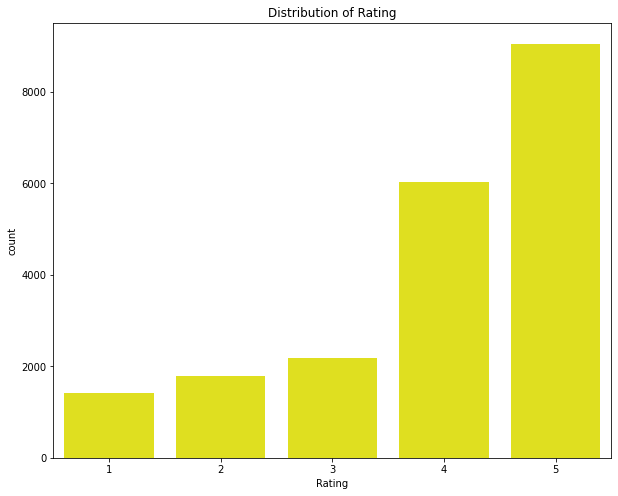

In [57]:
# Lets check the spread of ratings in our dataframe
plt.figure(figsize=(10, 8))
sns.countplot(df.Rating, color="yellow")
plt.title("Distribution of Rating")

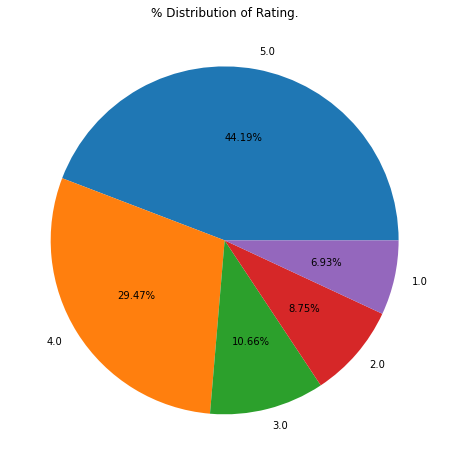

In [58]:
# % of distribution of ratings across the dataset
plt.figure(figsize=(10,8))
plt.pie(df['Rating'].value_counts(),labels=['5.0','4.0','3.0','2.0','1.0'], autopct='%1.2f%%')
plt.title("% Distribution of Rating.");

In [59]:
df.duplicated().sum()

0

### From the dataset, we can conclude that:
    * The data does not have any null values or any un-acceptable values in Review and well as in Rating column.
    * The data is in required format (The categories are already in numerical format).
    * The data does have a Categorical imbalance. (There are no equal amount of Ratings in the dataset. The Ratings are maximum for `5` and minimum for `1`.

### Preprocessing

In [60]:
# Let's make a function to genrate WordCloud

def create_wordcloud(condition):
    """
    Takes the condition on the data which you want to generate a wordcloud and returns wordcloud image.
    Use plt.imshow() to view the generated wordcloud.
    """
    plt.figure(figsize=(20,20))
    wc = WordCloud(max_words=2000,
                   min_font_size=10,
                   height=800,
                   width=1600,
                   background_color="white").generate(" ".join(condition))
    return wc

In [61]:
# Some text cleaning functions

def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [62]:
# Applying data cleaning functions to `Reviews`

df["preprocessed_review"] = df['Review'].apply(lambda x: convert_to_lower(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: remove_numbers(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: remove_punctuation(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: remove_stopwords(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: remove_extra_white_spaces(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: lemmatizing(x))
df.head()

,Review,Rating,preprocessed_review
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...


In [59]:
df2 = df.copy()
df2.head()

,Review,Rating,preprocessed_review
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...


In [60]:
# Calculating length before and after preprocessing

df2["length_before_cleaning"] = df2["Review"].apply(lambda x: len(x))
df2["length_after_cleaning"] = df2["preprocessed_review"].apply(lambda x: len(x))
df2.head()

,Review,Rating,preprocessed_review,length_before_cleaning,length_after_cleaning
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,593,542
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,1689,1570
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,1427,1313
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,600,562
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,1281,1171


In [61]:
# Dropping Rating column as we dont need it
df2.drop(["Rating"], axis=1, inplace=True)
df2.head()

,Review,preprocessed_review,length_before_cleaning,length_after_cleaning
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,593,542
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,1689,1570
2,nice rooms not 4* experience hotel monaco seat...,nice room experience hotel monaco seattle good...,1427,1313
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...,600,562
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...,1281,1171


In [62]:
df3 = df2.drop(["Review"], axis=1)
df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning
0,nice hotel expensive parking got good deal sta...,593,542
1,ok nothing special charge diamond member hilto...,1689,1570
2,nice room experience hotel monaco seattle good...,1427,1313
3,unique great stay wonderful time hotel monaco ...,600,562
4,great stay great stay went seahawk game awesom...,1281,1171


### Sentiment Analysis

**Note:** We used `Afinn Lexicon` for sentiment analysis.

In [63]:
# Sentiment analysis functions.

afinn = Afinn()

def afn_score(text):
    """Gives Afinn score provided to the text.
    """
    score = afinn.score(text)
    return score

In [64]:
df3["afinn_score"] = df3["preprocessed_review"].apply(afn_score)
df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning,afinn_score
0,nice hotel expensive parking got good deal sta...,593,542,26.0
1,ok nothing special charge diamond member hilto...,1689,1570,40.0
2,nice room experience hotel monaco seattle good...,1427,1313,20.0
3,unique great stay wonderful time hotel monaco ...,600,562,39.0
4,great stay great stay went seahawk game awesom...,1281,1171,40.0


In [66]:
# Label encoding `afinn_score`

def sentiment_analysis(score):
    """Checks the score. If the score < 0 then `1` and if the score > 0 then `-1` otherwise `0`.
    """
    if score > 0:
        return 1
    elif score < 0:
        return -1
    else:
        return 0


df3["sentiment"] = df3["afinn_score"].apply(sentiment_analysis) 
df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning,afinn_score,sentiment
0,nice hotel expensive parking got good deal sta...,593,542,26.0,1
1,ok nothing special charge diamond member hilto...,1689,1570,40.0,1
2,nice room experience hotel monaco seattle good...,1427,1313,20.0,1
3,unique great stay wonderful time hotel monaco ...,600,562,39.0,1
4,great stay great stay went seahawk game awesom...,1281,1171,40.0,1


In [67]:
df3.sentiment.value_counts()

 1    18992
-1     1294
 0      205
Name: sentiment, dtype: int64

In [68]:
# Saving the `preprocessed_dataframe`

df3.to_csv("Preprocessed-dataframe.csv", index=None)

In [64]:
df3 = pd.read_csv("/content/sample_data/Preprocessed-dataframe.csv")

### Model building & Experimentation

#### First we will try model building without balancing the dataframe

In [65]:
df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning,afinn_score,sentiment
0,nice hotel expensive parking got good deal sta...,593,542,26.0,1
1,ok nothing special charge diamond member hilto...,1689,1570,40.0,1
2,nice room experience hotel monaco seattle good...,1427,1313,20.0,1
3,unique great stay wonderful time hotel monaco ...,600,562,39.0,1
4,great stay great stay went seahawk game awesom...,1281,1171,40.0,1


In [66]:
df4 = df3.drop(["length_before_cleaning", "length_after_cleaning", "afinn_score"], axis=1)
df4.head()

,preprocessed_review,sentiment
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,1
2,nice room experience hotel monaco seattle good...,1
3,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay went seahawk game awesom...,1


In [67]:
# Vectorizing the `preprocessed_review`

tfidf_wo_balanc = TfidfVectorizer(max_features=5000)
X_tf_wob = tfidf_wo_balanc.fit_transform(df3["preprocessed_review"]).toarray()
X_tf_wob

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
print(X_tf_wob.shape)

(20491, 5000)


In [69]:
#Train test split

X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, df3["sentiment"].values, test_size=0.2)

**Naive Bayes**

In [22]:
# Instantiating model building
naiveBayes_wob = GaussianNB()

# FItting the train data
naiveBayes_wob.fit(X_train_tf_wob, y_train_tf_wob)

# Making predictions
y_pred_tf_wob = naiveBayes_wob.predict(X_test_tf_wob)

In [23]:
# Checking accuracy
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.7062698219077824


In [24]:
# Classification report
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

              precision    recall  f1-score   support

          -1       0.13      0.52      0.21       276
           0       0.02      0.04      0.03        47
           1       0.95      0.73      0.82      3776

    accuracy                           0.71      4099
   macro avg       0.37      0.43      0.35      4099
weighted avg       0.88      0.71      0.77      4099



**SVC**

In [16]:
Instantiating model building
svc_wob = SVC()

# FItting the train data
svc_wob.fit(X_train_tf_wob, y_train_tf_wob)

# Making predictions
y_pred_tf_wob = svc_wob.predict(X_test_tf_wob)

In [17]:
# Checking accuracy
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.945108563064162


In [18]:
# Classification report
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

              precision    recall  f1-score   support

          -1       0.90      0.39      0.54       276
           0       0.00      0.00      0.00        47
           1       0.95      1.00      0.97      3776

    accuracy                           0.95      4099
   macro avg       0.62      0.46      0.50      4099
weighted avg       0.93      0.95      0.93      4099



**KNN**

In [19]:
# Instantiating model building
knn_wob = KNeighborsClassifier()

# FItting the train data
knn_wob.fit(X_train_tf_wob, y_train_tf_wob)

# Making predictions
y_pred_tf_wob = knn_wob.predict(X_test_tf_wob)

In [20]:
# Checking accuracy
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.9243717979995121


In [21]:
# Classification report
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

              precision    recall  f1-score   support

          -1       0.57      0.17      0.26       276
           0       0.00      0.00      0.00        47
           1       0.93      0.99      0.96      3776

    accuracy                           0.92      4099
   macro avg       0.50      0.39      0.41      4099
weighted avg       0.90      0.92      0.90      4099



**Decision Tree**

In [25]:
# Instantiating model building
tree_wob = DecisionTreeClassifier()

# FItting the train data
tree_wob.fit(X_train_tf_wob, y_train_tf_wob)

# Making predictions
y_pred_tf_wob = tree_wob.predict(X_test_tf_wob)

In [26]:
# Checking accuracy
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.9133935106123445


In [27]:
# Classification report
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

              precision    recall  f1-score   support

          -1       0.45      0.43      0.44       276
           0       0.04      0.02      0.03        47
           1       0.95      0.96      0.96      3776

    accuracy                           0.91      4099
   macro avg       0.48      0.47      0.47      4099
weighted avg       0.91      0.91      0.91      4099



**All the above models are very similar in accuracy. But Decision tree classifier is doing well with classification. We will move forward with it**

In [70]:
# Let's try buiding a model with balanced dataframe

df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning,afinn_score,sentiment
0,nice hotel expensive parking got good deal sta...,593,542,26.0,1
1,ok nothing special charge diamond member hilto...,1689,1570,40.0,1
2,nice room experience hotel monaco seattle good...,1427,1313,20.0,1
3,unique great stay wonderful time hotel monaco ...,600,562,39.0,1
4,great stay great stay went seahawk game awesom...,1281,1171,40.0,1


In [71]:
df4 = df3.drop(["length_before_cleaning", "length_after_cleaning", "afinn_score"], axis=1)
df4.head()

,preprocessed_review,sentiment
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,1
2,nice room experience hotel monaco seattle good...,1
3,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay went seahawk game awesom...,1


In [72]:
df4_pos = df4[df4["sentiment"] ==1]
df4_pos.head()
len(df4_pos)

18992

In [73]:
# Down sampling positive reviews

df4_pos_sampled = df4_pos.sample(5000, replace=True)
df4_pos_sampled.head()

,preprocessed_review,sentiment
3907,glamour south ended southern island escaping c...,1
4586,nice hotel unfortunate city stayed mini suite ...,1
16840,class perfect location huge room fab view hote...,1
7556,great service frustrating internet access pro ...,1
2898,easy people vacation returned bavaro princess ...,1


In [74]:
# Making negative and neutral review dataframes

df4_neg = df4[df4["sentiment"] == -1]
df4_neut = df4[df4["sentiment"] == 0]

In [75]:
df4_neg.shape, df4_neut.shape

((1294, 2), (205, 2))

In [76]:
df5 = pd.concat([df4_pos_sampled, df4_neg, df4_neut], axis=0)
df5.shape

(6499, 2)

In [77]:
df5.head()

,preprocessed_review,sentiment
3907,glamour south ended southern island escaping c...,1
4586,nice hotel unfortunate city stayed mini suite ...,1
16840,class perfect location huge room fab view hote...,1
7556,great service frustrating internet access pro ...,1
2898,easy people vacation returned bavaro princess ...,1


In [78]:
df5.sentiment.value_counts()

 1    5000
-1    1294
 0     205
Name: sentiment, dtype: int64

In [81]:
# Let's do augmentation to balance the minority class
!pip install transformers
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 49.1 MB/s 
     |████████████████████████████████| 120 kB 74.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 4.7 MB/s 


In [82]:
import nlpaug.augmenter.word.context_word_embs as aug

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [111]:
# Let's see the working example

sample_text = df["preprocessed_review"].iloc[100]
sample_text

'great location staff location price make older hotel good choice staff friendly looking modern place old studio apartment building run hotel great neighborhood close great local resturants hotel sterile tourist feeling newer mid range hotel feel like small european hotel yes room use little moderizing compermise reservation stay'

In [112]:
# Initiate the augmentor

augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

In [113]:
augmented_sample_text = augmenter.augment(sample_text)
augmented_sample_text

['great location staff location price make older hotel good choice staff friendly looking modern new place old city studio apartment hotel building run hotel great garden neighborhood close school great local resturants have hotel sterile tourist friendly feeling newer mid range hotel feel less like small european hotel no yes room use little moderizing compermise reservation official stay']

In [114]:
df5["sentiment"].value_counts()

 1    5000
-1    1294
 0     205
Name: sentiment, dtype: int64

In [115]:
df6 = pd.concat([df4_pos_sampled, df4_neg], axis=0)
df6["sentiment"].value_counts()

 1    5000
-1    1294
Name: sentiment, dtype: int64

In [116]:
df4_neut["sentiment"].value_counts()

0    205
Name: sentiment, dtype: int64

In [117]:
# def augmentMyData(df, augmenter, repetitions=1, samples=200):
#     augmented_texts = []
#     # select only the minority class samples
#     spam_df = df[df["sentiment"] == -1].reset_index(drop=True) # removes unecessary index column
#     for i in tqdm(np.random.randint(0, len(spam_df), samples)):
#         # generating 'n_samples' augmented texts
#         for _ in range(repetitions):
#             augmented_text = augmenter.augment(spam_df["preprocessed_review"].iloc[i])
#             augmented_texts.append(augmented_text)
    
#     data = {
#         "sentiment": -1,
#         "preprocessed_review": augmented_texts
#     }
#     aug_df = pd.DataFrame(data)
#     df = shuffle(df.append(aug_df).reset_index(drop=True))
#     return df


# aug_df = augmentMyData(df6, augmenter, samples=1000)
# aug_df["sentiment"].value_counts()

  0%|          | 0/1000 [00:00<?, ?it/s]

 1    5000
-1    2294
Name: sentiment, dtype: int64

In [118]:
aug_df.to_csv("aug_data.csv", index=None)

In [131]:
aug_df = pd.read_csv("/content/aug_data.csv")

In [132]:
aug_df.sentiment.value_counts()

 1    5000
-1    2294
Name: sentiment, dtype: int64

In [133]:
df_neg = aug_df[aug_df["sentiment"] == -1]
df_neg.shape

(2294, 2)

In [134]:
df4_neut.shape

(205, 2)

In [135]:
neg_neut_df = pd.concat([df_neg, df4_neut], axis=0)
neg_neut_df.shape

(2499, 2)

In [123]:
neg_neut_df.sentiment.value_counts()

-1    2294
 0     205
Name: sentiment, dtype: int64

In [136]:
def augmentMyData(df, augmenter, repetitions=1, samples=200):
    augmented_texts = []
    # select only the minority class samples
    spam_df = df[df["sentiment"] == 0].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(spam_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(spam_df["preprocessed_review"].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        "sentiment": 0,
        "preprocessed_review": augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df


aug_neg_neut_df = augmentMyData(neg_neut_df, augmenter)
aug_neg_neut_df.sentiment.value_counts()

  0%|          | 0/200 [00:00<?, ?it/s]

-1    2294
 0     405
Name: sentiment, dtype: int64

In [137]:
aug_neg_neut_df.to_csv("aug_neg_neut_df.csv", index=False)

In [138]:
aug_neg_neut_df.sentiment.value_counts()

-1    2294
 0     405
Name: sentiment, dtype: int64

In [139]:
aug_neut_sent_df = aug_neg_neut_df[aug_neg_neut_df["sentiment"] == 0]
aug_neut_sent_df.sentiment.value_counts()

0    405
Name: sentiment, dtype: int64

In [140]:
final_df = pd.concat([aug_neut_sent_df, aug_df], axis=0)
final_df.sentiment.value_counts()

 1    5000
-1    2294
 0     405
Name: sentiment, dtype: int64

In [144]:
df10 = pd.DataFrame(final_df)
df10.head()

,preprocessed_review,sentiment
2319,missing hotel worth visiting room service prov...,0
2497,checkout fast drove unappealing alley hotel ta...,0
2334,place stay best thing said property location r...,0
2328,got sick trip started poorly given royal suite...,0
2583,[hot camp conquistador going caribbean preside...,0


In [157]:
# As some reviews changed to list we need to convert them into strings

df10 = df10.astype({"preprocessed_review": str})
df10.head()

,preprocessed_review,sentiment
2319,missing hotel worth visiting room service prov...,0
2497,checkout fast drove unappealing alley hotel ta...,0
2334,place stay best thing said property location r...,0
2328,got sick trip started poorly given royal suite...,0
2583,['hot camp conquistador going caribbean presid...,0


In [165]:
df4.head()

,preprocessed_review,sentiment
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,1
2,nice room experience hotel monaco seattle good...,1
3,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay went seahawk game awesom...,1


In [171]:
# split the dataset before augmenting to avoid augmented data in valid set
X_train, _, y_train, _ = train_test_split(df10["preprocessed_review"], df10["sentiment"].values, test_size=0.1)
_, X_test, _, y_test = train_test_split(df4["preprocessed_review"], df4["sentiment"].values, test_size=0.5)

In [172]:
tf_with_aug = TfidfVectorizer(max_features=5000)
X_train_tf = tf_with_aug.fit_transform(X_train)
X_train_tf = X_train_tf.toarray()

In [173]:
# Instantiating model building
tree_bal = DecisionTreeClassifier()

# FItting the train data
tree_bal.fit(X_train_tf, y_train)

# Transforming the test data
X_test_tf = tf_with_aug.transform(X_test).toarray()

# Making predictions
y_pred_tf = tree_bal.predict(X_test_tf)

In [174]:
# Checking accuracy
print(accuracy_score(y_test, y_pred_tf))

0.9189927776693344


In [175]:
# Classification report
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

          -1       0.51      0.97      0.67       691
           0       0.35      0.97      0.52        93
           1       1.00      0.91      0.95      9462

    accuracy                           0.92     10246
   macro avg       0.62      0.95      0.71     10246
weighted avg       0.96      0.92      0.93     10246



In [176]:
# We can see we have a great improvement with f1-scores in above trained model. Let's save the model and vectorizer.

import pickle

# Saving the vectorizer
pickle.dump(tf_with_aug, open("vectorizer_aug_tf.pickle", "wb"))

# Saving the model
pickle.dump(tree_bal, open("decsn_tree_trained_aug.pickle", "wb"))

In [ ]:
# Let's try to predict something



In [ ]:
def augmentMyData(df, augmenter, repetitions=1, samples=200):
    augmented_texts = []
    # select only the minority class samples
    spam_df = df[df["sentiment"] == 1].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(spam_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(spam_df["preprocessed_review"].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        "sentiment": -1,
        "preprocessed_review": augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df


aug_df_neutral = augmentMyData(df6, augmenter, samples=1000)
